In [1]:
from matplotlib import pyplot as plt
from tifffile import imread
import numpy as np
import pickle
from hydra.experimental import compose, initialize
import os
import torch
from lpu3dnet.frame import vqgan
from lpu3dnet.frame import transformer

# initialize configuration parameters for a specific experiment
experiment = 'ex6'
initialize(config_path=f"../config/{experiment}")
cfg_vqgan = compose(config_name="vqgan")
# cfg_transformer = compose(config_name="transformer")
cfg_dataset = compose(config_name="dataset")

/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/initialize.py:45: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize(
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)


In [2]:
from cpgan.ooppnm import img_process
img_prc = img_process.Image_process()
def gen_img_from_z(z):
    with torch.no_grad():
        img = model_vqgan.decode(z)
        img = img_prc.clean_img(img)
    return img

epoch_vqgan = 40
# epoch_transformer = 90
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_path = os.path.join(cfg_dataset.checkpoints.PATH, cfg_dataset.experiment)
vqgan_path = os.path.join(root_path,f'vqgan_epoch_{epoch_vqgan}.pth')
model_vqgan = vqgan.VQGAN(cfg_vqgan)
model_vqgan.load_checkpoint(vqgan_path)
model_vqgan = model_vqgan.to(device)
model_vqgan.eval()

VQGAN(
  (encoder): Encoder(
    (model): Sequential(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ResidualBlock(
        (block): Sequential(
          (0): GroupNorm(
            (gn): GroupNorm(16, 16, eps=1e-06, affine=True)
          )
          (1): Swish()
          (2): Conv3d(16, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): GroupNorm(
            (gn): GroupNorm(16, 64, eps=1e-06, affine=True)
          )
          (4): Swish()
          (5): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        )
        (channel_up): Conv3d(16, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      )
      (2): ResidualBlock(
        (block): Sequential(
          (0): GroupNorm(
            (gn): GroupNorm(16, 64, eps=1e-06, affine=True)
          )
          (1): Swish()
          (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): GroupNo

In [33]:
def compare_images(generated_images, original_images):
    """
    Display a comparison of generated images to original images
    :param generated_images: numpy array of shape (n, 1, 64, 64, 64)
    :param original_images: numpy array of shape (n, 1, 64, 64, 64)
    """
    
    # Ensure the shapes of the two image arrays are the same
    assert generated_images.shape == original_images.shape, "The generated images and original images should have the same shape."

    n = generated_images.shape[0]  # number of images
    
    # Create a figure
    fig, axes = plt.subplots(n, 2, figsize=(10, 5 * n))
    
    for i in range(n):
        # For single row subplot adjustment
        if n == 1:
            ax_gen = axes[0]
            ax_orig = axes[1]
        else:
            ax_gen = axes[i, 0]
            ax_orig = axes[i, 1]

        # Display generated image
        ax_gen.imshow(generated_images[i,0,::], cmap='gray')
        ax_gen.set_title(f'Generated Image {i+1}')
        ax_gen.axis('off')

        # Display original image
        ax_orig.imshow(original_images[i,0,::], cmap='gray')
        ax_orig.set_title(f'Original Image {i+1}')
        ax_orig.axis('off')
    
    plt.tight_layout()
    plt.show()

In [3]:
batch = 50
features_num = 64

min_val = 0
max_val = 3000

# Generate the random integer matrix as a PyTorch tensor
tokens_random = torch.randint(low=min_val, high=max_val, size=(batch, features_num)).to(device)
z_current = model_vqgan.tokens_to_z(tokens_random,total_features_vec_num=features_num)
img_cluster = gen_img_from_z(z_current)


In [ ]:
for img_idx in range(batch):
    f = plt.figure()
    plt.imshow(img_cluster[img_idx][0],cmap='gray')


#### Perturb codebook

In [34]:
batch = 2
features_num = 64

min_val = 0
max_val = 3000

# Generate the random integer matrix as a PyTorch tensor
tokens = torch.randint(low=min_val, high=max_val, size=(batch, features_num)).to(device)
z_current = model_vqgan.tokens_to_z(tokens,total_features_vec_num=features_num)

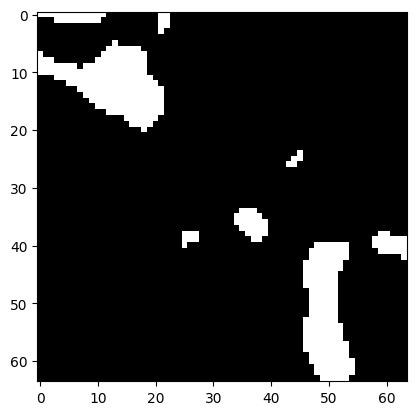

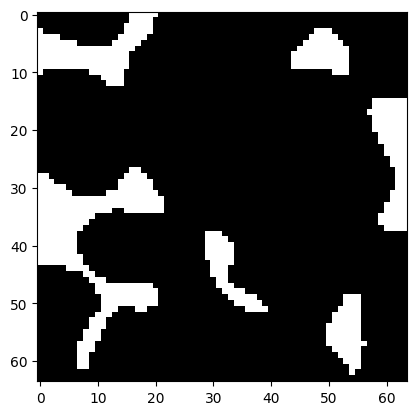

In [35]:
img_cluster = gen_img_from_z(z_current)
for img_idx in range(batch):
    f = plt.figure()
    plt.imshow(img_cluster[img_idx][0],cmap='gray')

In [36]:
def perturb_tensor_vectors(tensor, unperturbed_length, random_range):
    """
    Perturbs the elements of tensor vectors beyond a specified index with random values within a range.
    
    Args:
    tensor (torch.Tensor): Input tensor of shape (batch, idx_integers).
    unperturbed_length (int): Number of elements from the start of each vector that remain unchanged.
    random_range (tuple): The inclusive range (min, max) from which random integers are drawn.
    
    Returns:
    torch.Tensor: The perturbed tensor.
    """
    # Validate if the unperturbed length is within the tensor's second dimension
    if unperturbed_length > tensor.shape[1]:
        raise ValueError("Unperturbed length exceeds the tensor dimensions.")
    
    # Number of elements to perturb per vector
    perturb_length = tensor.shape[1] - unperturbed_length
    
    if perturb_length > 0:
        # Create random integers within the specified range for perturbation
        random_values = torch.randint(low=random_range[0], high=random_range[1], 
                                      size=(tensor.shape[0], perturb_length),
                                      dtype=tensor.dtype, device=tensor.device)
        
        # Replace the specified parts of the tensor with random values
        tensor[:, unperturbed_length:] = random_values
    
    return tensor



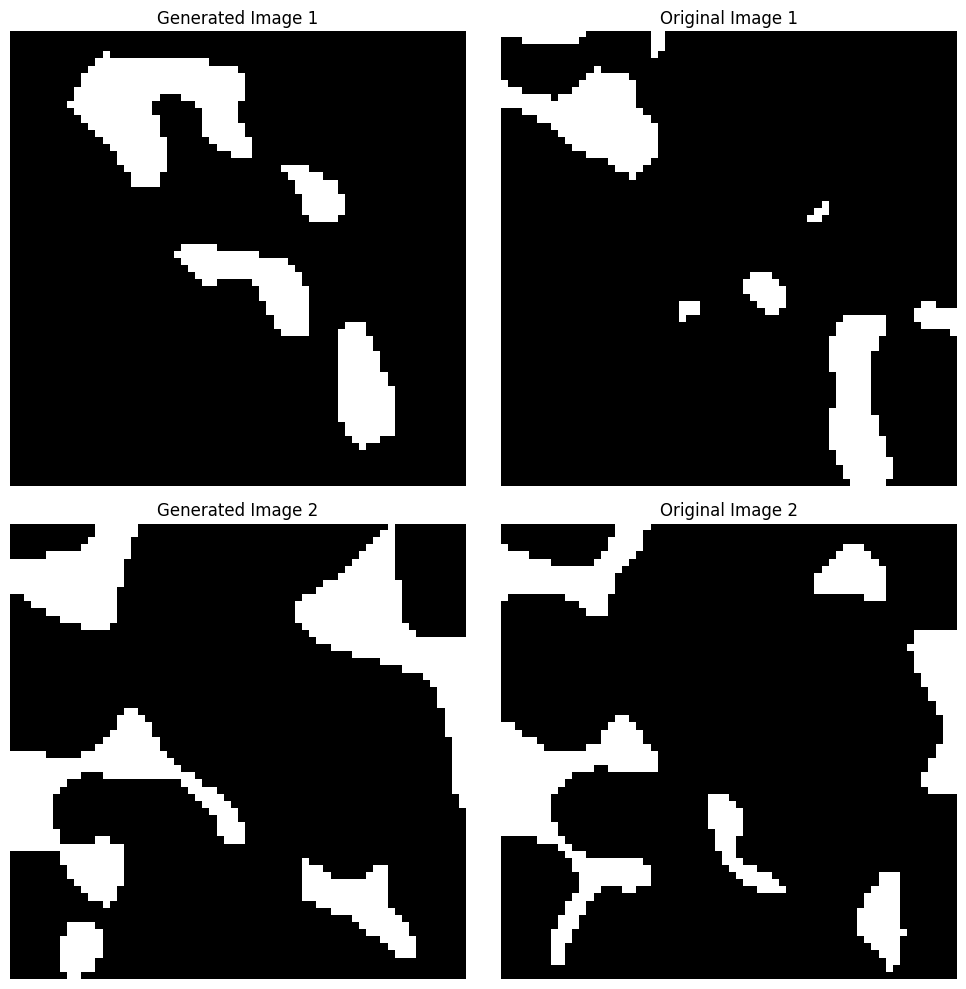

In [38]:
tokens_perturb = perturb_tensor_vectors(tokens, 34, (0, 3000))
z_perturb = model_vqgan.tokens_to_z(tokens_perturb,total_features_vec_num=features_num)
img_perturb = gen_img_from_z(z_perturb)

compare_images(img_perturb, img_cluster)

# for img_idx in range(batch):
#     f = plt.figure()
#     plt.imshow(img_cluster[img_idx][0],cmap='gray')